In [18]:
#!wget https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip -O data/chinook.zip && unzip data/chinook.zip -d data && rm data/chinook.zip

--2023-06-04 09:52:13--  https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip
Resolvendo www.sqlitetutorial.net (www.sqlitetutorial.net)... 151.139.128.10
Conectando-se a www.sqlitetutorial.net (www.sqlitetutorial.net)|151.139.128.10|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 305596 (298K) [application/zip]
Salvando em: “data/chinook.zip”

data/chinook.zip    100%[===================>] 298,43K  --.-KB/s    em 0,08s   

2023-06-04 09:52:13 (3,55 MB/s) - “data/chinook.zip” salvo [305596/305596]

Archive:  data/chinook.zip
  inflating: data/chinook.db         


In [1]:
import os
import sqlite3
import pandas as pd

from getpass import getpass
from langchain import SQLDatabase, SQLDatabaseChain
from langchain.agents import create_sql_agent, AgentExecutor
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.llms.openai import OpenAI
from langchain.sql_database import SQLDatabase

os.environ["OPENAI_API_KEY"] = getpass("Insert your openai api key:")

SQLITE_DATABASE_PATH = os.path.join(os.path.abspath("."), "data", "chinook.db")
SQLITE_DATABASE_URI = "sqlite:///"+SQLITE_DATABASE_PATH

Insert your openai api key: ········


In [2]:
conn = sqlite3.connect(SQLITE_DATABASE_PATH)

In [6]:
db = SQLDatabase.from_uri(SQLITE_DATABASE_URI)
llm = OpenAI(temperature=0, verbose=True)

# SQLDatabaseChain

O `SQLDatabaseChain` é utilizado para quando você quer utilizar o LLM para gerar códigos SQL para você interagir com a base de dados.

In [8]:
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [50]:
db_chain.run("Quais as tabelas que estão nessa base de dados?")



> Entering new SQLDatabaseChain chain...
Quais as tabelas que estão nessa base de dados?
SQLQuery:SELECT name FROM sqlite_master WHERE type='table';
SQLResult: [('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]
Answer:albums, sqlite_sequence, artists, customers, employees, genres, invoices, invoice_items, media_types, playlists, playlist_track, tracks, sqlite_stat1.
> Finished chain.


'albums, sqlite_sequence, artists, customers, employees, genres, invoices, invoice_items, media_types, playlists, playlist_track, tracks, sqlite_stat1.'

In [52]:
db_chain.run("Qual cliente mais comprou discos?")



> Entering new SQLDatabaseChain chain...
Qual cliente mais comprou discos?
SQLQuery:SELECT "FirstName", "LastName", SUM("Quantity") AS "Total" FROM customers 
          INNER JOIN invoices ON customers."CustomerId" = invoices."CustomerId" 
          INNER JOIN invoice_items ON invoices."InvoiceId" = invoice_items."InvoiceId" 
          GROUP BY customers."CustomerId" 
          ORDER BY "Total" DESC 
          LIMIT 5;
SQLResult: [('Luís', 'Gonçalves', 38), ('Leonie', 'Köhler', 38), ('François', 'Tremblay', 38), ('Bjørn', 'Hansen', 38), ('František', 'Wichterlová', 38)]
Answer:O cliente que mais comprou discos foi Luís Gonçalves.
> Finished chain.


'O cliente que mais comprou discos foi Luís Gonçalves.'

In [55]:
db_chain.run("Quantas vendas foram registradas?")



> Entering new SQLDatabaseChain chain...
Quantas vendas foram registradas?
SQLQuery:SELECT COUNT(*) FROM invoices;
SQLResult: [(412,)]
Answer:412 vendas foram registradas.
> Finished chain.


'412 vendas foram registradas.'

Porém, em alguns casos, podemos ter alguns error com o código SQL gerado. Por exemplo:

In [9]:
try:
    db_chain.run("Qual o gênero mais vende?")
except Exception as err:
    print(err)



> Entering new SQLDatabaseChain chain...
Qual o gênero mais vende?
SQLQuery:

/home/eduardo/anaconda3/lib/python3.10/site-packages/langchain/sql_database.py:311: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  sample_rows_result = connection.execute(command)  # type: ignore


SELECT "Name", COUNT(*) AS "Total" FROM genres 
          INNER JOIN tracks ON genres."GenreId" = tracks."GenreId" 
          INNER JOIN invoice_items ON tracks."TrackId" = invoice_items."TrackId" 
          GROUP BY genres."Name" 
          ORDER BY "Total" DESC 
          LIMIT 5;(sqlite3.OperationalError) ambiguous column name: Name
[SQL: SELECT "Name", COUNT(*) AS "Total" FROM genres 
          INNER JOIN tracks ON genres."GenreId" = tracks."GenreId" 
          INNER JOIN invoice_items ON tracks."TrackId" = invoice_items."TrackId" 
          GROUP BY genres."Name" 
          ORDER BY "Total" DESC 
          LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


Além disso, para análises que não sejam a geração de código SQL, essa cadeia não é a adequada.

In [10]:
try:
    db_chain.run("Pode me descrever do que se trata essa base de dados?")
except Exception as err:
    print(err)



> Entering new SQLDatabaseChain chain...
Pode me descrever do que se trata essa base de dados?
SQLQuery:SELECT * FROM artists, employees, genres, media_types, playlists, albums, customers, invoices, tracks, invoice_items, playlist_track LIMIT 5;
SQLResult: [(1, 'AC/DC', 1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com', 1, 'Rock', 1, 'MPEG audio file', 1, 'Music', 1, 'For Those About To Rock We Salute You', 1, 1, 'Luís', 'Gonçalves', 'Embraer - Empresa Brasileira de Aeronáutica S.A.', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', '+55 (12) 3923-5555', '+55 (12) 3923-5566', 'luisg@embraer.com.br', 3, 1, 2, '2009-01-01 00:00:00', 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', 1.98, 1, 'For Those About To Rock (We Salute You)', 1, 1, 1, 'Angus Young, Malcolm 

Nesses casos, deve-se trabalhar com o agente SQL:

# SQL Agent

In [11]:
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents import create_sql_agent

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True
)

In [12]:
description = agent_executor.run("Pode me descrever essa base de dados?")

description



> Entering new AgentExecutor chain...
Action: list_tables_sql_db
Action Input: ""
Observation: genres, tracks, sqlite_sequence, albums, employees, invoices, playlists, artists, invoice_items, playlist_track, sqlite_stat1, customers, media_types
Thought: I should look at the schema of the tables to get a better understanding of the data.
Action: schema_sql_db
Action Input: "genres, tracks, albums, employees, invoices, playlists, artists, invoice_items, playlist_track, customers, media_types"
Observation: 
CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE employees (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(30), 
	"ReportsTo" INTEGER, 
	"BirthDate" DATETIME, 
	"HireDate" DATETIME, 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Cou

'Esta base de dados contém tabelas para artistas, empregados, gêneros, tipos de mídia, listas de reprodução, álbuns, clientes, faturas, itens de fatura e faixas de lista de reprodução. Cada tabela tem seu próprio conjunto de colunas que armazenam informações relevantes.'

Com o agente, não estamos limitados à códigos SQL. Podemos misturar linguagem natural, com outros códigos (no exemplo, usei DOT para geração de diagramas)



> Entering new AgentExecutor chain...
Action: list_tables_sql_db
Action Input: ""
Observation: genres, tracks, sqlite_sequence, albums, employees, invoices, playlists, artists, invoice_items, playlist_track, sqlite_stat1, customers, media_types
Thought: I should look at the schema of the tables to see what the relationships are.
Action: schema_sql_db
Action Input: "genres, tracks, albums, employees, invoices, playlists, artists, invoice_items, playlist_track, customers, media_types"
Observation: 
CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE employees (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(30), 
	"ReportsTo" INTEGER, 
	"BirthDate" DATETIME, 
	"HireDate" DATETIME, 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NV

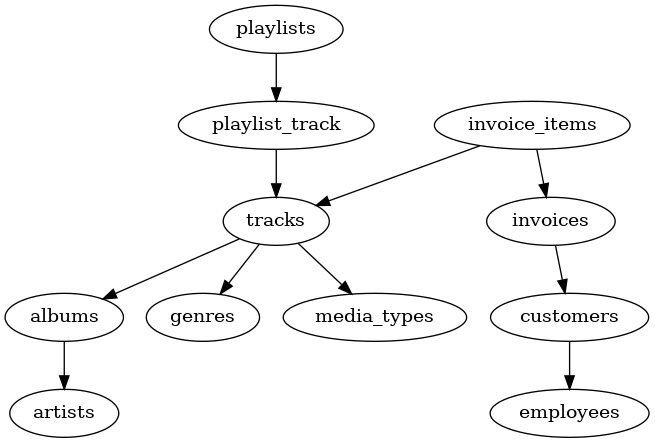

In [15]:
from graphviz import Source

code = agent_executor.run("Could you generate a DOT code of entity-relation diagram of this database?")

with open("data/diagram.dot", "w") as file:
    file.write(code)

print("DOT code =", code)

s = Source(code, filename="data/diagram", format="png")

display(Image.open('data/diagram.png'))